# Отток клиентов

[Введение](#beginning)

1. [Подготовка данных](#preparing)


2. [Исследование задачи](#research)


3. [Борьба с дисбалансом](#modelling)


4. [Тестирование модели](#testing)


5. [Общий вывод](#finalizing)  

<a id="beginning"></a>
# Введение

В ходе данной работы будут проанализированы данные об оттоке клиентов банка. И построена модель для задач классификации, которая сможет прогнозировать, уйдёт клиент в ближайшее время из банка или нет.

<a id="preparing"></a>
# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
total_clients = 10000

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1.000,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8.000,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,125510.820,1,1,1,79084.100,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,10000.000,10000.000,10000.000,9091.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,15690940.569,650.529,38.922,4.998,76485.889,1.530,0.706,0.515,100090.240,0.204
std,2886.896,71936.186,96.653,10.488,2.895,62397.405,0.582,0.456,0.500,57510.493,0.403
min,1.000,15565701.000,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,2500.750,15628528.250,584.000,32.000,2.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,5000.500,15690738.000,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,7500.250,15753233.750,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.247,0.000
max,10000.000,15815690.000,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


Приведём названия столбцов к нижнему регистру.

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

Удалим столбцы с фамилией и идентификаторами клиентов, чтобы не путать модель при обучении.

In [9]:
del data['surname']
del data['customerid']
del data['rownumber']

Пропуски есть только в столбце tenure - заполним их нулями, т.к. здесь пропуски означают, что у клиента нет объектов недвижимости.

In [10]:
data['tenure'] = data['tenure'].fillna(0)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Создадим Dummy-переменные для столбцов geography, gender, tenure, numofproducts. Применим параметр drop_first=True, чтобы избежать dummy-ловушки.

In [12]:
data_ohe = pd.get_dummies(data=data, columns=['geography', 'gender', 'tenure', 'numofproducts'], drop_first=True)
data_ohe.head()

,creditscore,age,balance,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0,numofproducts_2,numofproducts_3,numofproducts_4
0,619,42,0.000,1,1,101348.880,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,608,41,83807.860,0,1,112542.580,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,502,42,159660.800,1,0,113931.570,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,699,39,0.000,0,0,93826.630,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,850,43,125510.820,1,1,79084.100,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Посмотрим на сбалансированность целевого признака

In [13]:
data_ohe_grouped = data_ohe.groupby(['exited']).agg({'estimatedsalary': ['count']})
data_ohe_grouped.columns = ['count']
data_ohe_grouped['percent'] = data_ohe_grouped['count']/total_clients
display(data_ohe_grouped)

,count,percent
exited,,
0,7963,0.796
1,2037,0.204


Около 80% выборки - существующие клиенты. И лишь 20% - ушедшие. Выборка несбалансированна. Метрику accuracy для оценки создаваемых моделей в данном случае будет применять некорректно. Остановимся на сравнении метрик F1 и AUC-ROC. В данной задаче для нас будет важнее метрика F1, т.к. нам очень важно удержать существующих клиентов, т.е. предсказать факт ухода.

Разделим данные на обучающую (train), валидационную (valid) и тестовую (test) выборки в соотношении 60% - 20% - 20%. И извлечём признаки для обучения: целевой - target, остальные - features

In [14]:
data_ohe_middle, data_ohe_test = train_test_split(data_ohe, test_size=0.2, random_state=12345)
data_ohe_train, data_ohe_valid = train_test_split(data_ohe_middle, test_size=0.25, random_state=12345)

In [15]:
features_train = data_ohe_train.drop(['exited'], axis=1)
target_train = data_ohe_train['exited']
features_valid = data_ohe_valid.drop(['exited'], axis=1)
target_valid = data_ohe_valid['exited'] 
features_test = data_ohe_test.drop(['exited'], axis=1)
target_test = data_ohe_test['exited'] 

In [16]:
print(data_ohe_train.shape)
print(data_ohe_valid.shape)
print(data_ohe_test.shape)
data_ohe_train_total = 6000
data_ohe_valid_total = 2000
data_ohe_test_total = 2000

(6000, 23)
(2000, 23)
(2000, 23)


Масштабируем численные переменные

In [17]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']

In [18]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [19]:
display(features_test.head())

,creditscore,age,balance,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0,numofproducts_2,numofproducts_3,numofproducts_4
7867,-0.124,0.685,-1.232,1,1,0.980,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1402,1.083,-0.937,0.859,1,0,-0.390,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
8606,1.599,0.304,-1.232,1,1,-0.435,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
8885,0.165,0.590,0.412,1,1,1.017,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
6494,0.485,-1.032,-1.232,1,1,-1.344,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


***Вывод***

Данные были подготовлены к обучению: отредактированы названия столбцов, удалены ненужные для моделирования столбцы, заполнены пропуски, созданы dummy-переменные, численные признаки масштабированы, затем данные были разделены на обучающую, валидационную и тестовую выборки. 

<a id="research"></a>
# 2. Исследование задачи

Проверим, сохранились ли в созданных обучающей, валидационноц и тестовой выборках изначальные пропорции классов.

In [20]:
display(target_train.value_counts(normalize=True))
display(target_valid.value_counts(normalize=True))
display(target_test.value_counts(normalize=True))

0   0.797
1   0.203
Name: exited, dtype: float64

0   0.804
1   0.196
Name: exited, dtype: float64

0   0.786
1   0.213
Name: exited, dtype: float64

Обучим модель без учёта дисбаланса классов:

In [21]:
model_before_balance = DecisionTreeClassifier(random_state=12345)

model_before_balance.fit(features_train, target_train)
predicted_valid_before_balance = model_before_balance.predict(features_valid)
accuracy_valid_before_balance = accuracy_score(target_valid, predicted_valid_before_balance) 
display(accuracy_valid_before_balance)



0.7885

Проверку на адекватность модель не прошла, accuracy меньше изначальной доли нулевого класса.

In [22]:
print(confusion_matrix(target_valid, predicted_valid_before_balance))

[[1387  222]
 [ 201  190]]


In [23]:
print("F1:", f1_score(target_valid, predicted_valid_before_balance))

F1: 0.47322540473225405


In [24]:
probabilities_valid_before_balance = model_before_balance.predict_proba(features_valid)
probabilities_one_valid_before_balance = probabilities_valid_before_balance[:, 1]

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid_before_balance))

AUC-ROC: 0.6739798035029938


***Вывод***

Около 80% выборки - существующие клиенты. И лишь 20% - ушедшие. Выборка несбалансированна. Метрику accuracy для оценки создаваемых моделей в данном случае будет применять некорректно. Остановимся на сравнении метрик F1 и AUC-ROC. В данной задаче для нас будет важнее метрика F1, т.к. нам очень важно удержать существующих клиентов, т.е. предсказать факт ухода.
Созданная без учёта дисбаланса классов модель проверку на адекватность не прошла. Будем бороться с дисбалансом.

<a id="modelling"></a>
# 3. Борьба с дисбалансом

# 3.1.  Взвешивание классов

Придадим объектам редкого класса больший вес, задав параметр class_weight='balanced' трём моделям: решающего дерева, случайного леса и логистической регрессии с разными гиперпараметрами.

In [25]:
model_weighted = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_weighted.fit(features_train, target_train)
predicted_valid_weighted = model_weighted.predict(features_valid)
print("F1 для модели логистической регрессии:", f1_score(target_valid, predicted_valid_weighted))
probabilities_valid_weighted = model_weighted.predict_proba(features_valid)
probabilities_one_valid_weighted = probabilities_valid_weighted[:, 1]
print("AUC-ROC для модели логистической регрессии:", roc_auc_score(target_valid, probabilities_one_valid_weighted))

F1 для модели логистической регрессии: 0.5426653883029722
AUC-ROC для модели логистической регрессии: 0.8323751150418285


In [26]:
for depth in range(1, 11):
    model_tree_weighted = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree_weighted.fit(features_train, target_train)
    predictions_tree_valid_weighted = model_tree_weighted.predict(features_valid)  
    print("max_depth =", depth, ": ", end='')
    print("F1:", f1_score(target_valid, predictions_tree_valid_weighted))
    probabilities_valid_tree_weighted = model_tree_weighted.predict_proba(features_valid)
    probabilities_one_valid_tree_weighted = probabilities_valid_tree_weighted[:, 1]
    print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid_tree_weighted))

max_depth = 1 : F1: 0.4750733137829912
AUC-ROC: 0.6898591522430575
max_depth = 2 : F1: 0.5161290322580645
AUC-ROC: 0.7668954522117437
max_depth = 3 : F1: 0.5402425578831312
AUC-ROC: 0.8031485299283602
max_depth = 4 : F1: 0.5359999999999999
AUC-ROC: 0.8126356063002389
max_depth = 5 : F1: 0.5446507515473034
AUC-ROC: 0.8268610549037622
max_depth = 6 : F1: 0.5645472061657033
AUC-ROC: 0.825414587701214
max_depth = 7 : F1: 0.5416248746238717
AUC-ROC: 0.806918087039177
max_depth = 8 : F1: 0.5498426023084995
AUC-ROC: 0.7899411717020152
max_depth = 9 : F1: 0.5067961165048543
AUC-ROC: 0.7640351030568142
max_depth = 10 : F1: 0.5040485829959513
AUC-ROC: 0.7504557961212426


Наилучший результат F1 - 0,565 и AUC-ROC = 0.825 из моделей решающего дерева был получен для глубины 6

In [27]:
best_model_forest_weighted = None
best_result_forest_weighted = 0
best_est_forest_weighted = 0
best_depth_forest_weighted = 0
best_roc_auc_score_weighted = 0 
for est in range(10, 101, 10):
    for depth_forest in range (1, 11):
        model_forest_weighted = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth_forest, class_weight='balanced')
        model_forest_weighted.fit(features_train, target_train)
        predictions_forest_valid_weighted = model_forest_weighted.predict(features_valid)
        result_forest_weighted = f1_score(target_valid, predictions_forest_valid_weighted)
        probabilities_valid_forest_weighted = model_forest_weighted.predict_proba(features_valid)
        probabilities_one_valid_forest_weighted = probabilities_valid_forest_weighted[:, 1]
        roc_auc_score_weighted = roc_auc_score(target_valid, probabilities_one_valid_tree_weighted)
        if result_forest_weighted > best_result_forest_weighted:
            best_model_forest_weighted = model_forest_weighted
            best_result_forest_weighted = result_forest_weighted
            best_est_forest_weighted = est
            best_depth_forest_weighted = depth_forest
            best_roc_auc_score_weighted = roc_auc_score_weighted

print("F1 наилучшей модели случайного леса на валидационной выборке:", best_result_forest_weighted,"AUC-ROC:", best_roc_auc_score_weighted, "Количество деревьев:", best_est_forest_weighted, "Глубина:", best_depth_forest_weighted)

F1 наилучшей модели случайного леса на валидационной выборке: 0.5969802555168408 AUC-ROC: 0.7504557961212426 Количество деревьев: 20 Глубина: 9


***Вывод***

При использовании метода взвешивания для борьбы с дисбалансом классов наилучший результат получается у модели случайного леса с 20 деревьями и глубиной 9.

# 3.2. Увеличение выборки

Создадим функцию upsample, которая разделяет выборку на отрицательные и положительные объекты, дублирует объекты положительного класса, объединяет с объектами отрицательного класса и перемешивает. Затем применим её к нашим данным.

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)


In [29]:
display(target_upsampled.value_counts(normalize=True))

1   0.560
0   0.440
Name: exited, dtype: float64

Обучим на увеличенной выборке модель **логистической регрессии**:

In [30]:
model_upsampled_logistic = LogisticRegression(random_state=12345, solver='liblinear')
model_upsampled_logistic.fit(features_upsampled, target_upsampled)
predicted_valid_upsampled_logistic = model_upsampled_logistic.predict(features_valid)

print("F1 для логистической регрессии:", f1_score(target_valid, predicted_valid_upsampled_logistic))
probabilities_valid_upsampled_logistic = model_upsampled_logistic.predict_proba(features_valid)
probabilities_one_valid_upsampled_logistic = probabilities_valid_upsampled_logistic[:, 1]
print("AUC-ROC для логистической регрессии:", roc_auc_score(target_valid, probabilities_one_valid_upsampled_logistic))

F1 для логистической регрессии: 0.5223251895534962
AUC-ROC для логистической регрессии: 0.8324657179325374


Обучим на увеличенной выборке модель **решающего дерева**:

In [31]:
for depth in range(1, 11):
    model_tree_upsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_upsampled.fit(features_upsampled, target_upsampled)
    predictions_tree_valid_upsampled = model_tree_upsampled.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1:", f1_score(target_valid, predictions_tree_valid_upsampled))
    probabilities_valid_tree_upsampled = model_tree_upsampled.predict_proba(features_valid)
    probabilities_one_valid_tree_upsampled = probabilities_valid_tree_upsampled[:, 1]
    print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid_tree_upsampled))

max_depth = 1 : F1: 0.4750733137829912
AUC-ROC: 0.6898591522430575
max_depth = 2 : F1: 0.4369063772048846
AUC-ROC: 0.7668954522117437
max_depth = 3 : F1: 0.5402425578831312
AUC-ROC: 0.8031485299283602
max_depth = 4 : F1: 0.5261121856866537
AUC-ROC: 0.8116779178502
max_depth = 5 : F1: 0.5341296928327646
AUC-ROC: 0.82197088309207
max_depth = 6 : F1: 0.5509641873278237
AUC-ROC: 0.8197701865624786
max_depth = 7 : F1: 0.5384615384615384
AUC-ROC: 0.805174378774127
max_depth = 8 : F1: 0.5485485485485484
AUC-ROC: 0.7773942608632071
max_depth = 9 : F1: 0.5047984644913628
AUC-ROC: 0.7490927789496105
max_depth = 10 : F1: 0.4924528301886793
AUC-ROC: 0.7382887816136534


Наилучший результат F1 - 0,55 и AUC-ROC = 0,82 из моделей решающего дерева был получен для глубины 6

Обучим на увеличенной выборке модели **случайного леса** с числом деревьев от 10 до 100 с шагом в 10, с глубиной от 1 до 10. И посчитаем F1 на валидационной выборке:

In [32]:
best_model_forest_upsampled = None
best_result_forest_upsampled = 0
best_est_forest_upsampled = 0
best_depth_forest_upsampled = 0
best_roc_auc_score_upsampled = 0 
for est in range(10, 101, 10):
    for depth_forest in range (1, 11):
        model_forest_upsampled = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth_forest)
        model_forest_upsampled.fit(features_upsampled, target_upsampled)
        predictions_forest_valid_upsampled = model_forest_upsampled.predict(features_valid)
        result_forest_upsampled = f1_score(target_valid, predictions_forest_valid_upsampled)
        probabilities_valid_forest_upsampled = model_forest_upsampled.predict_proba(features_valid)
        probabilities_one_valid_forest_upsampled = probabilities_valid_forest_upsampled[:, 1]
        roc_auc_score_upsampled = roc_auc_score(target_valid, probabilities_one_valid_forest_upsampled)
        if result_forest_upsampled > best_result_forest_upsampled:
            best_model_forest_upsampled = model_forest_upsampled
            best_result_forest_upsampled = result_forest_upsampled
            best_est_forest_upsampled = est
            best_depth_forest_upsampled = depth_forest
            best_roc_auc_score_upsampled = roc_auc_score_upsampled

print("F1 наилучшей модели случайного леса на валидационной выборке:", best_result_forest_upsampled, "AUC-ROC:", best_roc_auc_score_upsampled, "Количество деревьев:", best_est_forest_upsampled, "Глубина:", best_depth_forest_upsampled)

F1 наилучшей модели случайного леса на валидационной выборке: 0.5737538148524924 AUC-ROC: 0.851765723177968 Количество деревьев: 60 Глубина: 10


***Вывод***

При использовании метода увеличения выборки для борьбы с дисбалансом классов наилучший результат получается у модели случайного леса с 60 деревьями и глубиной 10.

# 3.3. Уменьшение выборки

Создадим функцию downsample, которая разделяет выборку на отрицательные и положительные объекты, случайным образом отбрасывает часть объектов отрицательного класса и перемешивает данные. Затем применим её к нашим данным.

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

In [34]:
display(target_downsampled.value_counts(normalize=True))

0   0.541
1   0.459
Name: exited, dtype: float64

Обучим на уменьшенной выборке модель **логистической регрессии**:

In [35]:
model_downsampled_logistic = LogisticRegression(random_state=12345, solver='liblinear')
model_downsampled_logistic.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_logistic = model_downsampled_logistic.predict(features_valid)

print("F1 для логистической регрессии:", f1_score(target_valid, predicted_valid_downsampled_logistic))
probabilities_valid_downsampled_logistic = model_downsampled_logistic.predict_proba(features_valid)
probabilities_one_valid_downsampled_logistic = probabilities_valid_downsampled_logistic[:, 1]
print("AUC-ROC для логистической регрессии:", roc_auc_score(target_valid, probabilities_one_valid_downsampled_logistic))

F1 для логистической регрессии: 0.54323499491353
AUC-ROC для логистической регрессии: 0.8334973192671021


Обучим на уменьшенной выборке модель **решающего дерева**:

In [36]:
for depth in range(1, 11):
    model_tree_downsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_downsampled.fit(features_downsampled, target_downsampled)
    predictions_tree_valid_downsampled = model_tree_downsampled.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1:", f1_score(target_valid, predictions_tree_valid_downsampled))
    probabilities_valid_tree_downsampled = model_tree_downsampled.predict_proba(features_valid)
    probabilities_one_valid_tree_downsampled = probabilities_valid_tree_downsampled[:, 1]
    print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid_tree_downsampled))

max_depth = 1 : F1: 0.4750733137829912
AUC-ROC: 0.6898591522430575
max_depth = 2 : F1: 0.5161290322580645
AUC-ROC: 0.7668954522117437
max_depth = 3 : F1: 0.5402425578831312
AUC-ROC: 0.8035633957963438
max_depth = 4 : F1: 0.5240431795878313
AUC-ROC: 0.8129757645214976
max_depth = 5 : F1: 0.5500945179584121
AUC-ROC: 0.8340472947089501
max_depth = 6 : F1: 0.5413687436159346
AUC-ROC: 0.824535580708896
max_depth = 7 : F1: 0.5423076923076923
AUC-ROC: 0.810856928498424
max_depth = 8 : F1: 0.5414585414585414
AUC-ROC: 0.7956396166702961
max_depth = 9 : F1: 0.5288932419196866
AUC-ROC: 0.7694736607859562
max_depth = 10 : F1: 0.5004668534080299
AUC-ROC: 0.7470232181828875


Наилучший результат F1 - 0,55 был получен для глубины 5

Обучим на уменьшенной выборке модели **случайного леса** с числом деревьев от 10 до 100 с шагом в 10, с глубиной от 1 до 10. И посчитаем F1 на валидационной выборке:

In [37]:
best_model_forest_downsampled = None
best_result_forest_downsampled = 0
best_est_forest_downsampled = 0
best_depth_forest_downsampled = 0
best_roc_auc_score_downsampled = 0 
for est in range(10, 101, 10):
    for depth_forest in range (1, 11):
        model_forest_downsampled = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth_forest)
        model_forest_downsampled.fit(features_downsampled, target_downsampled)
        predictions_forest_valid_downsampled = model_forest_downsampled.predict(features_valid)
        result_forest_downsampled = f1_score(target_valid, predictions_forest_valid_downsampled)
        probabilities_valid_forest_downsampled = model_forest_downsampled.predict_proba(features_valid)
        probabilities_one_valid_forest_downsampled = probabilities_valid_forest_downsampled[:, 1]
        roc_auc_score_downsampled = roc_auc_score(target_valid, probabilities_one_valid_forest_downsampled)
        if result_forest_downsampled > best_result_forest_downsampled:
            best_model_forest_downsampled = model_forest_downsampled
            best_result_forest_downsampled = result_forest_downsampled
            best_est_forest_downsampled = est
            best_depth_forest_downsampled = depth_forest
            best_roc_auc_score_downsampled = roc_auc_score_downsampled

print("F1 наилучшей модели случайного леса на валидационной выборке:", best_result_forest_downsampled, "AUC-ROC:", best_roc_auc_score_downsampled, "Количество деревьев:", best_est_forest_downsampled, "Глубина:", best_depth_forest_downsampled)

F1 наилучшей модели случайного леса на валидационной выборке: 0.5868392664509169 AUC-ROC: 0.8504352912565032 Количество деревьев: 60 Глубина: 9


***Вывод***

При использовании метода увеличения выборки для борьбы с дисбалансом классов наилучший результат получается у модели случайного леса с 60 деревьями и глубиной 9.

<a id="testing"></a>
# 4. Тестирование модели

Проверим выбранную нами наилучшую модель (модель случайного леса с 20 деревьями и глубиной 9, полученную методом взвешивания выборки) на тестовой выборке.

In [38]:
model_forest_weighted_best = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=9, class_weight='balanced')
model_forest_weighted_best.fit(features_train, target_train)
predictions_forest_valid_weighted = model_forest_weighted_best.predict(features_valid)
predictions_forest_test_weighted = model_forest_weighted_best.predict(features_test)
print("F1 на валидационной выборке:", f1_score(target_valid, predictions_forest_valid_weighted))
print("F1 на тестовой выборке:", f1_score(target_test, predictions_forest_test_weighted))
probabilities_valid_forest_weighted = model_forest_weighted_best.predict_proba(features_valid)
probabilities_one_valid_forest_weighted = probabilities_valid_forest_weighted[:, 1]
print("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid_tree_weighted))
probabilities_test_forest_weighted = model_forest_weighted_best.predict_proba(features_test)
probabilities_one_test_forest_weighted = probabilities_test_forest_weighted[:, 1]
print("AUC-ROC на тестовой выборке:", roc_auc_score(target_test, probabilities_one_test_forest_weighted))

F1 на валидационной выборке: 0.5969802555168408
F1 на тестовой выборке: 0.6461211477151967
AUC-ROC на валидационной выборке: 0.7504557961212426
AUC-ROC на тестовой выборке: 0.8666043345626058


In [39]:
print(confusion_matrix(target_test, predictions_forest_test_weighted))

[[1363  210]
 [ 123  304]]


Text(0.5, 1.0, 'ROC-кривая лучшей модели на тестовой выборке')

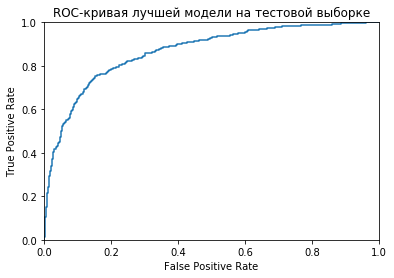

In [40]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_forest_weighted)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая лучшей модели на тестовой выборке')

***Вывод***:

Модель случайного леса с 20 деревьями и глубиной 9, полученная методом взвешивания выборки, показала хорошие результаты при тестировании - F1 на тестовой выборке: 0.65, AUC-ROC на тестовой выборке: 0.87; что позволит «Бета-Банку» предсказать уход клиентов и удержать их.

<a id="finalizing"></a>
# 5. Общий вывод

- В ходе данной работы были проанализированы данные об оттоке клиентов Бета-банка.

- Около 80% выборки - существующие клиенты. И лишь 20% - ушедшие. Выборка несбалансированна. Метрику accuracy для оценки создаваемых моделей в данном случае будет применять некорректно. Поэтому сравнение моделей идёт по метрикам F1 и AUC-ROC. В данной задаче для нас будет важнее метрика F1, т.к. нам очень важно удержать существующих клиентов, т.е. предсказать факт ухода.

- Данные были подготовлены к обучению: отредактированы названия столбцов, удалены ненужные для моделирования столбцы, заполнены пропуски, созданы dummy-переменные, численные признаки масштабированы, затем данные были разделены на обучающую, валидационную и тестовую выборки. 

- Было использовано 3 метода борьбы с дисбалансом: метод взвешивания, метод увеличения выборки и метод уменьшения выборки. Для каждого метода было построено и обучено три модели: решающего дерева, случайного леса и логистической регрессии с разными гиперпараметрами.

- При использовании метода взвешивания для борьбы с дисбалансом классов наилучший результат получается у модели случайного леса с 20 деревьями и глубиной 9. Она же оказалась наилучшей моделью по итогам использования всех трёх методов.

- При использовании метода увеличения выборки для борьбы с дисбалансом классов наилучший результат получается у модели случайного леса с 60 деревьями и глубиной 10.

- При использовании метода увеличения выборки для борьбы с дисбалансом классов наилучший результат получается у модели случайного леса с 60 деревьями и глубиной 9.

- Модель случайного леса с 20 деревьями и глубиной 9, полученная методом взвешивания выборки, показала хорошие результаты при тестировании - F1 на тестовой выборке: 0.65, AUC-ROC на тестовой выборке: 0.87; что позволит «Бета-Банку» предсказать уход клиентов и удержать их.